In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-11-03_16-51_20200101_20200831_lock_periods_by_4.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
df[df['reason']=='CLOSE'].realizedPNL.count()/df.realizedPNL.count()*2

0.0028308563340410475

In [5]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [6]:
#df = df.loc['20190101':'20190701']

In [7]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [8]:
allocs

YM       0.25
NQ       0.25
GC       0.25
ES       0.25
total    1.00
dtype: float64

In [9]:
df.groupby('contract').realizedPNL.sum()

contract
ES     3538.6
GC    17344.0
NQ    12647.8
YM    20818.4
Name: realizedPNL, dtype: float64

In [10]:
df.realizedPNL.sum()

54348.8

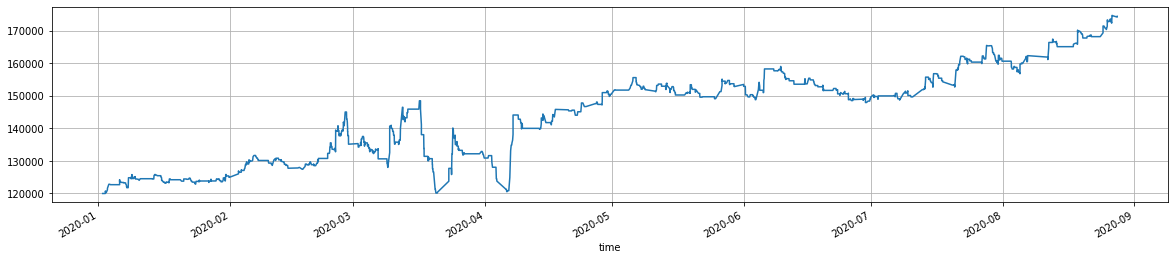

In [11]:
df.cash.plot(figsize=(20,4), grid=True);

In [12]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [13]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES    185
 GC    300
 NQ    732
 YM    196
 Name: action, dtype: int64,
 1413)

In [14]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.075581
 GC    1.744186
 NQ    4.255814
 YM    1.139535
 Name: action, dtype: float64,
 8.215116279069768)

In [15]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES     388.5
GC     726.0
NQ    1537.2
YM     411.6
Name: commission, dtype: float64

In [16]:
df.commission.sum()

3063.3

In [17]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
NQ,0.43,34.56,724.84,-483.98,1.50,35.81,366.0
GC,0.37,115.63,1232.43,-530.95,2.32,121.50,150.0
YM,0.51,212.43,1203.00,-819.41,1.47,212.02,98.0
ES,0.40,38.46,1635.33,-1035.79,1.58,32.66,92.0
total,0.42,76.98,1010.84,-609.07,1.66,71.29,706.0


In [18]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [19]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.135758,0.232644,0.616837,0.782207
GC,0.135758,1.000000,-0.151656,0.062150,0.497703
NQ,0.232644,-0.151656,1.000000,0.109904,0.496491
YM,0.616837,0.062150,0.109904,1.000000,0.657438
total,0.782207,0.497703,0.496491,0.657438,1.000000


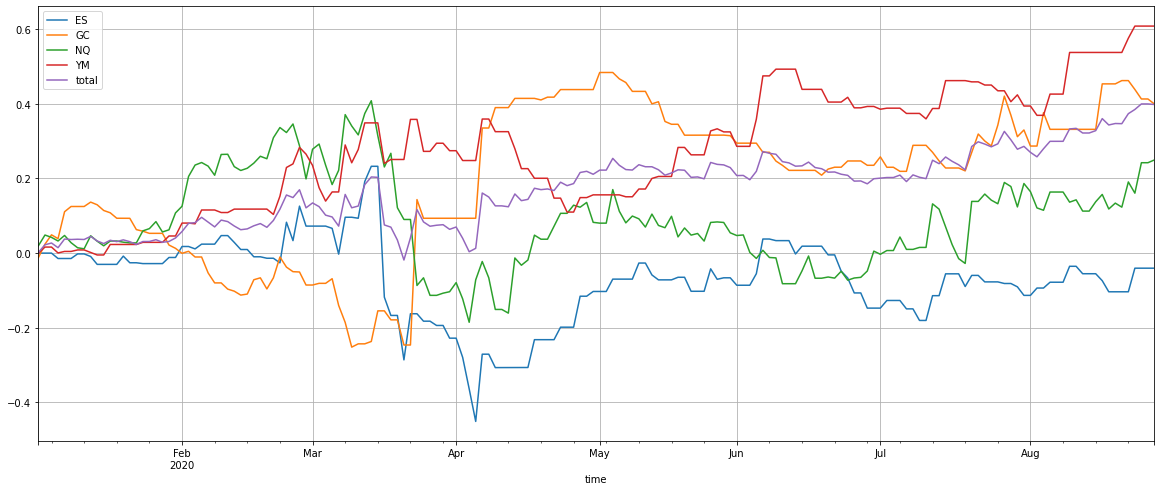

In [20]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

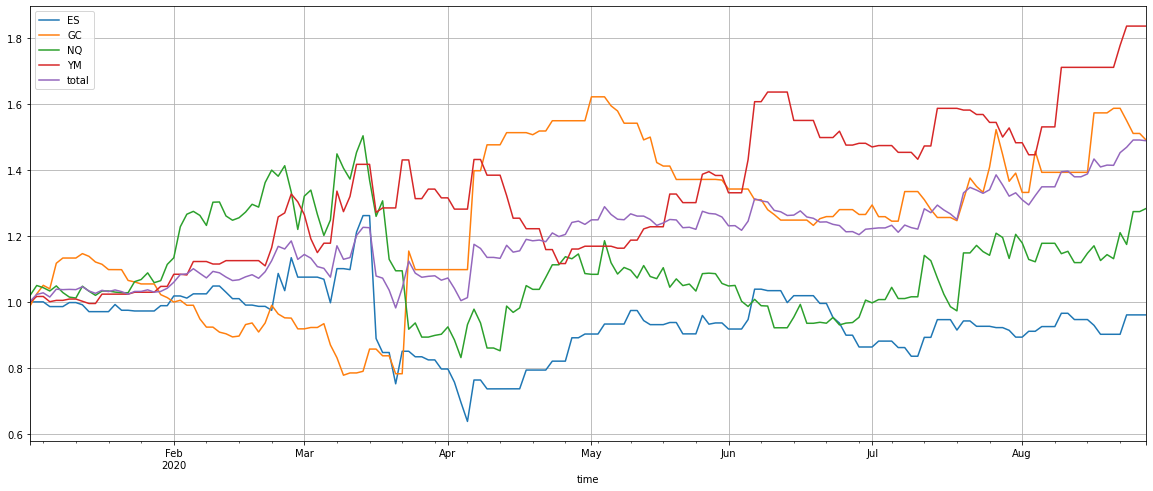

In [21]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [22]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,-0.057409,0.795078,0.441626,1.437619,0.791936
Cumulative returns,-0.039550,0.490809,0.283581,0.837044,0.489027
Annual volatility,0.667607,0.789231,0.716373,0.507055,0.404258
Sharpe ratio,0.258858,1.073238,0.862237,2.005131,1.641428
Calmar ratio,-0.115950,2.469797,0.986643,6.517236,3.970673
Stability,0.045575,0.445420,0.013816,0.792787,0.838049
Max drawdown,-0.495123,-0.321920,-0.447604,-0.220587,-0.199446
Omega ratio,1.072621,1.419996,1.176683,1.664119,1.411744
Sortino ratio,0.370118,3.195147,1.370017,3.870667,2.947070
Skew,-0.966338,6.118241,0.563847,1.349445,1.295407


In [ ]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

In [ ]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

In [ ]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

In [ ]:
daily.sort_values('total', ascending=False)